# STATISTICS ABOUT DATASET AND SIMULATION
In this notebook, you can produce interesting plots and statistics about the datasets and the attack simulation we have presented in the paper.

## IMPORT

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib.ticker import MaxNLocator
from nltk.stem import PorterStemmer
import csv
import json
import os
import urllib.parse
import pandas as pd
from tqdm.notebook import tqdm

## LOAD DATASETS

In [19]:
# load train, valid and test from LM_datasets
data_folder='LM_datasets'
train_df = pd.read_csv(os.path.join(data_folder, 'train.csv'))
validation_df = pd.read_csv(os.path.join(data_folder, 'validation.csv'))
test_df = pd.read_csv(os.path.join(data_folder, 'test.csv'))

In [20]:
# train websites per type
types=train_df['Type'].unique()
print("Split should be 70-10-20\n")
set_types=['train','validation','test']
types_sizes={}
for t in types:
    train_size=train_df[train_df['Type']==t]['Filename'].nunique()
    validation_size=validation_df[validation_df['Type']==t]['Filename'].nunique()
    test_size=test_df[test_df['Type']==t]['Filename'].nunique()
    types_sizes[t]=[train_size,validation_size,test_size]

for t in types_sizes:
    total_size=sum(types_sizes[t])
    print(f'{t}: {types_sizes[t][0]} websites in train ({types_sizes[t][0]/total_size*100:.2f}%), {types_sizes[t][1]} websites in validation ({types_sizes[t][1]/total_size*100:.2f}%), {types_sizes[t][2]} websites in test ({types_sizes[t][2]/total_size*100:.2f}%)')


    


    

Split should be 70-10-20

university: 55 websites in train (62.50%), 12 websites in validation (13.64%), 21 websites in test (23.86%)
hospital: 54 websites in train (67.50%), 7 websites in validation (8.75%), 19 websites in test (23.75%)
company: 69 websites in train (71.13%), 10 websites in validation (10.31%), 18 websites in test (18.56%)
government: 242 websites in train (72.02%), 33 websites in validation (9.82%), 61 websites in test (18.15%)


In [21]:
df=pd.concat([train_df,validation_df,test_df],ignore_index=True)
df.head()

,Type,Filename,Path
0,university,https__www.ucl.ac.uk_.csv,/giving/case-studies/2023/feb/ucl-and-santande...
1,university,https__www.cmu.edu_.csv,/homepage/health/2008/fall
2,university,https__www.psu.edu_.csv,/news/academics/story/application-window-open-...
3,university,https__www.bristol.ac.uk_.csv,/study/postgraduate/taught/msc-policy-research
4,university,https__www.durham.ac.uk_.csv,/staff/m-f-roger


In [22]:
# Duplicate the df, but for the duplicated data the type is 'all'
df_all = df.copy()
df_all['Type'] = 'all'
df = pd.concat([df, df_all], ignore_index=True)

## DIRECTORY SET SIMILARITY BETWEEN DATASETS

In [23]:
# FIRST SIMILARITY, GET DIRECTORY SET FOR EVERY DATASET AND PLOT HEATMAP

# from df, for each type, get the set of directories


df['Path'] = df['Path'].apply(lambda x: x.lstrip('/'))  # Remove leading slashes

# Split each path into directories
df['Directories'] = df['Path'].apply(lambda x: x.split('/'))

df.head()

,Type,Filename,Path,Directories
0,university,https__www.ucl.ac.uk_.csv,giving/case-studies/2023/feb/ucl-and-santander...,"[giving, case-studies, 2023, feb, ucl-and-sant..."
1,university,https__www.cmu.edu_.csv,homepage/health/2008/fall,"[homepage, health, 2008, fall]"
2,university,https__www.psu.edu_.csv,news/academics/story/application-window-open-u...,"[news, academics, story, application-window-op..."
3,university,https__www.bristol.ac.uk_.csv,study/postgraduate/taught/msc-policy-research,"[study, postgraduate, taught, msc-policy-resea..."
4,university,https__www.durham.ac.uk_.csv,staff/m-f-roger,"[staff, m-f-roger]"


In [26]:
## mean
types=df['Type'].unique()

for type in types:
    type_df=df[df['Type']==type]
    websites=type_df['Filename'].unique()
    website_path_sizes=[]
    for website in websites:
        website_df=type_df[type_df['Filename']==website]
        website_path_sizes.append(len(website_df['Path'].unique()))
    
    print(type, "average number of paths per website", np.mean(website_path_sizes), "standard deviation", np.std(website_path_sizes))

university average number of paths per website 2301.5454545454545 standard deviation 2906.115037566519
hospital average number of paths per website 2584.875 standard deviation 2800.0274524323863
company average number of paths per website 1479.1340206185566 standard deviation 2360.377549866708
government average number of paths per website 1507.5386904761904 standard deviation 2340.4462152756864
all average number of paths per website 1767.0383973288815 standard deviation 2537.509297043541


In [27]:
# Get the set of directories for each type
types = df['Type'].unique()
type_directories = {}

for t in types:
    type_df=df[df['Type']==t]
    type_directories[t] = {}
    for website in type_df['Filename'].unique():
        website_df=type_df[type_df['Filename']==website]
        directories = set()
        for d in website_df['Directories']:
            directories.update(d)
        for d in directories:
            if d not in type_directories[t]:
                type_directories[t][d] = 0
            type_directories[t][d] += 1

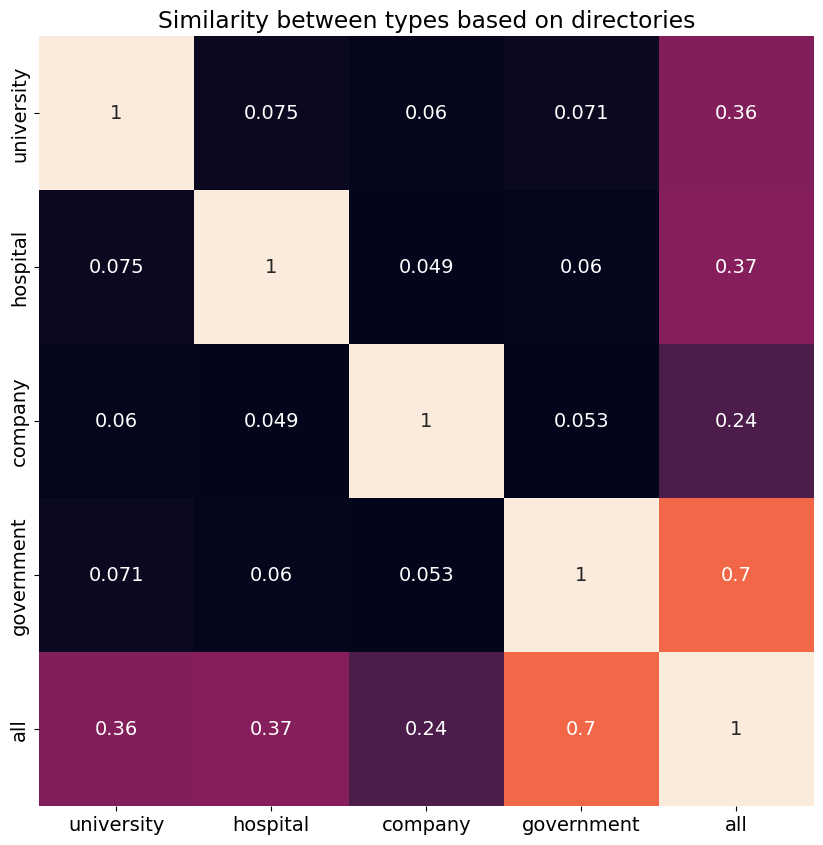

In [28]:
# Plot heatmap showing for each couple of type the number of common directories / number of total directories
similarity = np.zeros((len(types), len(types)))
for i, t1 in enumerate(types):
    for j, t2 in enumerate(types):
        common_directories= type_directories[t1].keys() & type_directories[t2].keys()
        intersection_value=0
        for d in common_directories:
            intersection_value+=type_directories[t1][d]+type_directories[t2][d]
        total_value=sum(type_directories[t1].values())+sum(type_directories[t2].values())
        similarity[i, j] = intersection_value/total_value
plt.rcParams['font.size'] = 14
plt.figure(figsize=(10, 10))
sns.heatmap(similarity, annot=True, xticklabels=types, yticklabels=types,cbar=False)
plt.title('Similarity between types based on directories')
plt.show()


## COMMON PATHS SIMILARITY BETWEEN DATASETS

In [30]:
# 2ND SIMILARITY, MEASURES HOW PATHS IN COMMON (LIKELY TO BE VERY LOW)

# Get the set of paths for each type
type_paths = {}

for t in types:
    type_df=df[df['Type']==t]
    type_paths[t] = {}
    for website in type_df['Filename'].unique():
        website_df=type_df[type_df['Filename']==website]
        paths = set()
        for p in website_df['Path']:
            paths.add(p)
        for p in paths:
            if p not in type_paths[t]:
                type_paths[t][p] = 0
            type_paths[t][p] += 1

In [31]:
for i, t1 in enumerate(types):
    for j, t2 in enumerate(types):
        common_paths= type_paths[t1].keys() & type_paths[t2].keys()
        print("Datasets:",t1,"-",t2, "common paths: ",len(common_paths))

Datasets: university - university common paths:  201768
Datasets: university - hospital common paths:  171
Datasets: university - company common paths:  115
Datasets: university - government common paths:  254
Datasets: university - all common paths:  201768
Datasets: hospital - university common paths:  171
Datasets: hospital - hospital common paths:  205587
Datasets: hospital - company common paths:  153
Datasets: hospital - government common paths:  306
Datasets: hospital - all common paths:  205587
Datasets: company - university common paths:  115
Datasets: company - hospital common paths:  153
Datasets: company - company common paths:  143067
Datasets: company - government common paths:  1126
Datasets: company - all common paths:  143067
Datasets: government - university common paths:  254
Datasets: government - hospital common paths:  306
Datasets: government - company common paths:  1126
Datasets: government - government common paths:  502693
Datasets: government - all common pa

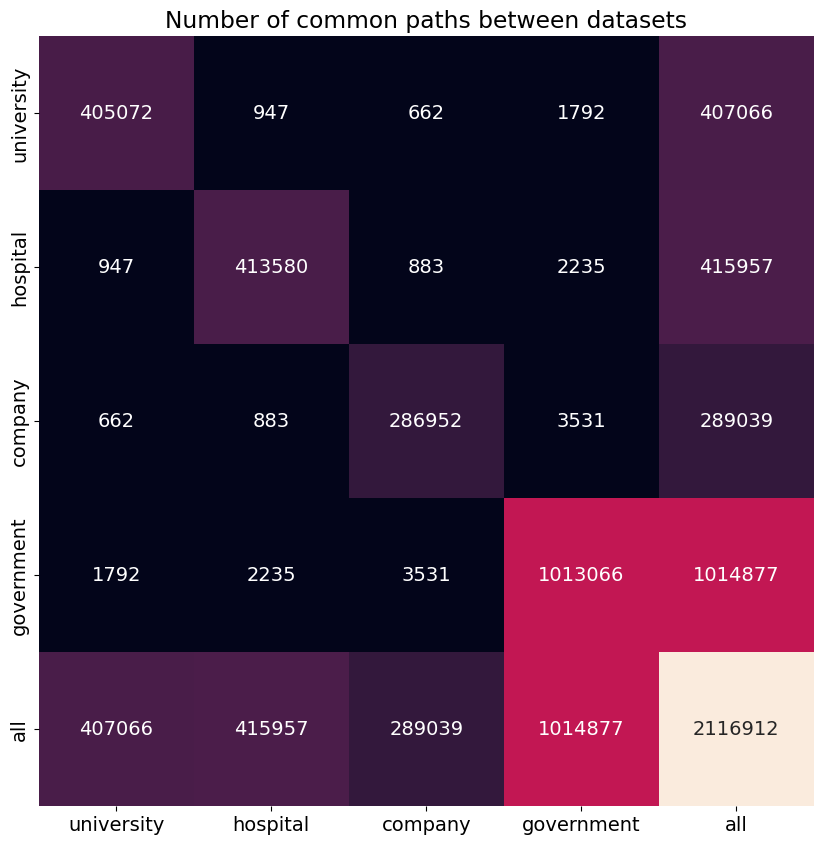

In [32]:
# Plot heatmap showing for each couple of type the number of common paths
similarity = np.zeros((len(types), len(types)))
for i, t1 in enumerate(types):
    for j, t2 in enumerate(types):
        common_paths= type_paths[t1].keys() & type_paths[t2].keys()
        intersection_value=0
        for p in common_paths:
            intersection_value+=type_paths[t1][p]+type_paths[t2][p]
        total_value=sum(type_paths[t1].values())+sum(type_paths[t2].values())
        similarity[i, j] = intersection_value
        
plt.figure(figsize=(10, 10))

sns.heatmap(similarity, annot=True, xticklabels=types, yticklabels=types, fmt='.0f', cbar=False)
plt.title('Number of common paths between datasets')

plt.show()

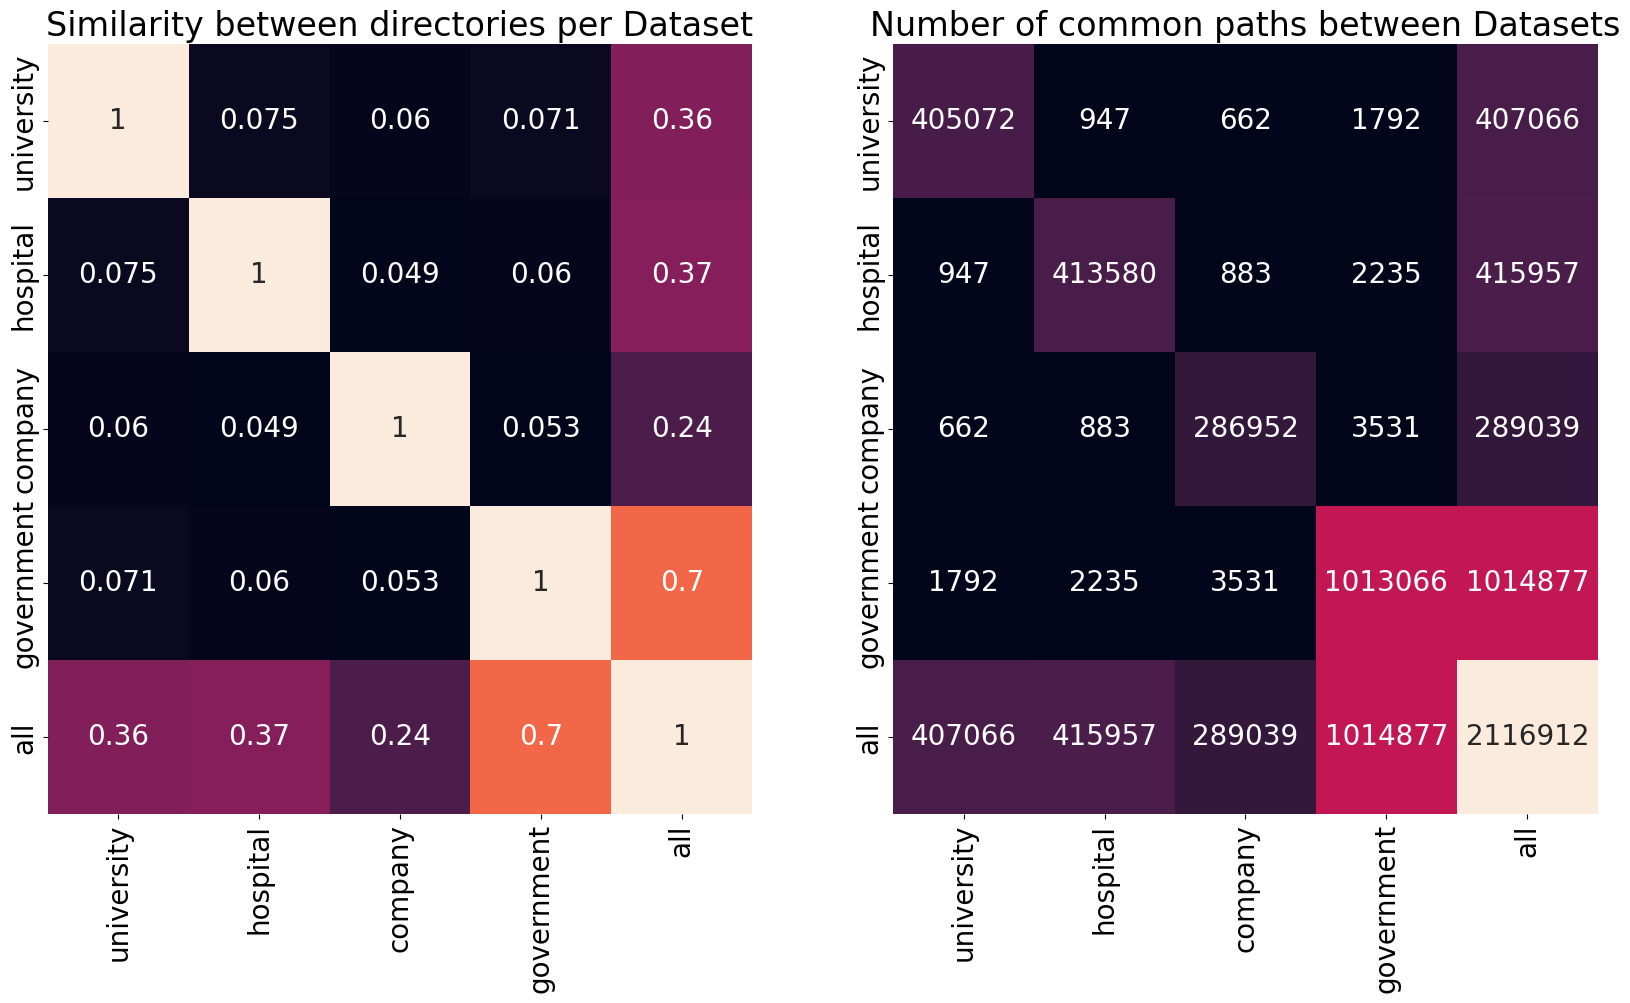

In [33]:
#Print similarities side by side

# Set font size
plt.rcParams['font.size'] = 20

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot heatmap showing for each couple of type the number of common directories / number of total directories
similarity = np.zeros((len(types), len(types)))
for i, t1 in enumerate(types):
    for j, t2 in enumerate(types):
        common_directories= type_directories[t1].keys() & type_directories[t2].keys()
        intersection_value=0
        for d in common_directories:
            intersection_value+=type_directories[t1][d]+type_directories[t2][d]
        total_value=sum(type_directories[t1].values())+sum(type_directories[t2].values())
        similarity[i, j] = intersection_value/total_value

# Plot the first heatmap
sns.heatmap(similarity, annot=True, xticklabels=types, yticklabels=types,cbar=False, ax=axs[0])
axs[0].set_title('Similarity between directories per Dataset')

# Plot heatmap showing for each couple of type the number of common paths
similarity = np.zeros((len(types), len(types)))
for i, t1 in enumerate(types):
    for j, t2 in enumerate(types):
        common_paths= type_paths[t1].keys() & type_paths[t2].keys()
        intersection_value=0
        for p in common_paths:
            intersection_value+=type_paths[t1][p]+type_paths[t2][p]
        total_value=sum(type_paths[t1].values())+sum(type_paths[t2].values())
        similarity[i, j] = intersection_value

# Plot the second heatmap
sns.heatmap(similarity, annot=True, xticklabels=types, yticklabels=types, fmt='.0f', cbar=False, ax=axs[1])
axs[1].set_title('Number of common paths between Datasets')

# Show the plot
plt.show()


## STATISTICS ABOUT EACH DATASET
Data presented for each dataset:
- number of unique domains
- number of paths
- number of directories
- number of unique directories
- Depth AVG
- Depth STD

In [ ]:
# For each type of dataset, print type and how many unique and total directories
for t in types:
    if t=='all':
        continue
    local_df=df[df["Type"]==t]
    print(t)
    print("Unique domains", local_df['Filename'].nunique())
    print("Paths", local_df['Path'].nunique())
    print(f'Unique directories: {len(type_directories[t])}')
    print(f'Total directories: {len(df[df["Type"] == t])}')
    print(f'Depth Average: {np.mean([len(directory_list) for directory_list in local_df["Directories"]])}')
    print(f'Depth Standard Deviation: {np.std([len(directory_list) for directory_list in local_df["Directories"]])}')

## WORDLIST COVERAGE WITH INCREASING DEPTH

In [36]:
wordlists_folder = 'chosen_wordlists'

selected_wordlists = []  # Store the selected wordlists

for root, dirs, files in os.walk(wordlists_folder):
    for filename in files:
        if filename.endswith('.txt'):
            selected_wordlists.append(os.path.join(root, filename))

wordlists = []

for wordlist_file in selected_wordlists:
    with open(wordlist_file, 'r') as file:
        wordlist_content = file.read()
        wordlist_words = wordlist_content.split()  # Split the content into words
        wordlist_set = set(wordlist_words)  # Create a set from the words
        wordlists.append((os.path.basename(wordlist_file), wordlist_set))


In [29]:
for i in range(len(wordlists)):
    wordlists[i]=(wordlists[i][0].rstrip('.txt'),wordlists[i][1])
    print(wordlists[i][0])

big_wfuzz
directory-list_dirbuster
megabeast_wfuzz
top_10k_github


In [37]:
def coverage_per_depth(wordlist, df, depth):
    covered_directories=[]
    all_directories=[]
    websites=df['Filename'].unique()
    for website in websites:
        website_df=df[df['Filename']==website]
        directories=set()
        for path_list in website_df['Directories']:
            if depth<len(path_list):
                directories.add(path_list[depth])
        
        all_directories=all_directories+list(directories)
        for directory in directories:
            if directory in wordlist:
                covered_directories.append(directory)
    return len(covered_directories)/len(all_directories)

In [ ]:
# Plot 4 coverage plots side to side in 1 row for each dataset type, where in each plot we show the coverage of every wordlist at different depths
max_depth=10
types=df['Type'].unique()
coverages={}

for i, t in enumerate(types):
    for wordlist_name, wordlist in wordlists:
        coverage = [coverage_per_depth(wordlist, df[df['Type'] == t], depth+1) for depth in range(max_depth)]
        coverages[(t, wordlist_name)]= coverage


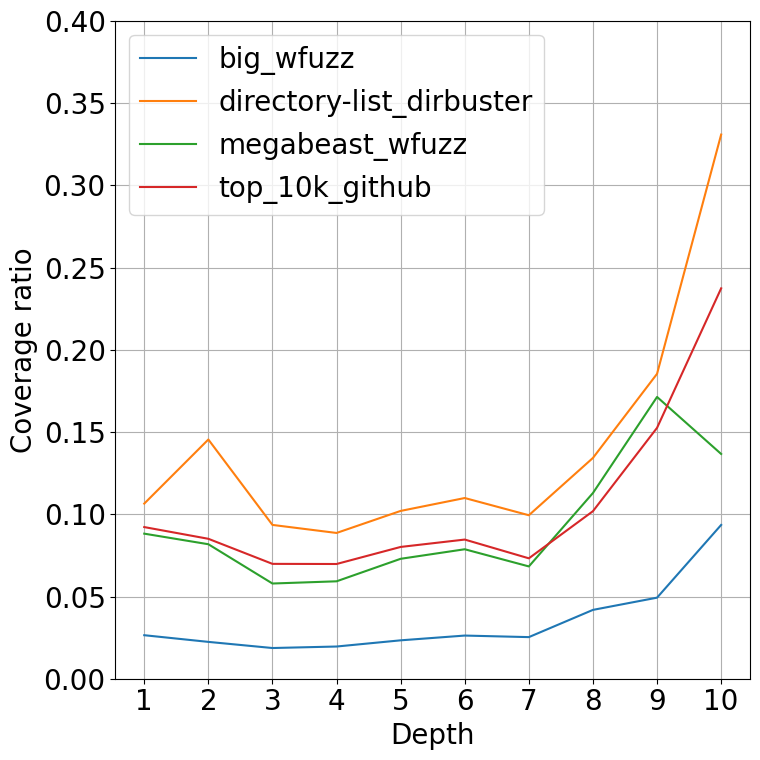

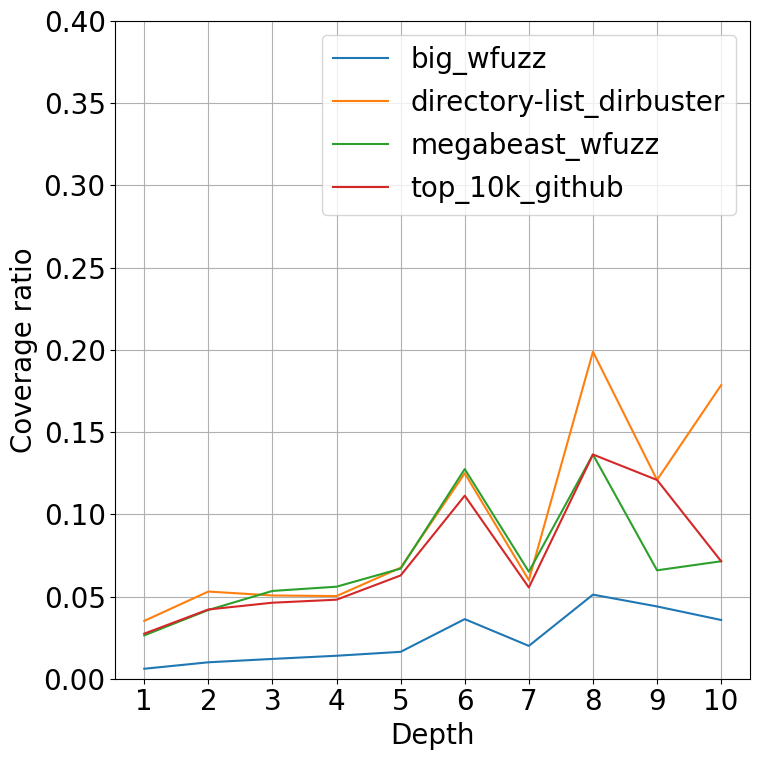

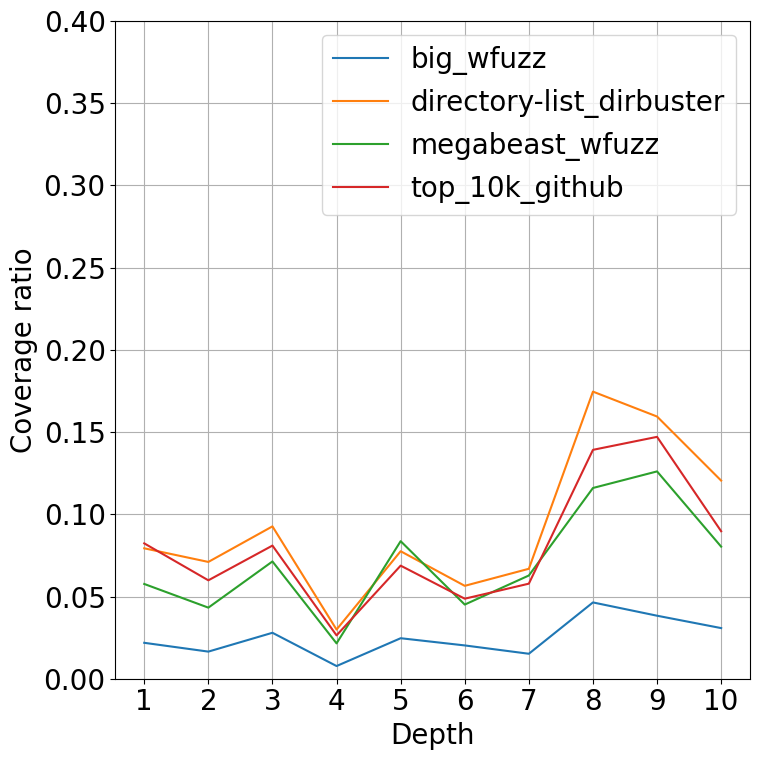

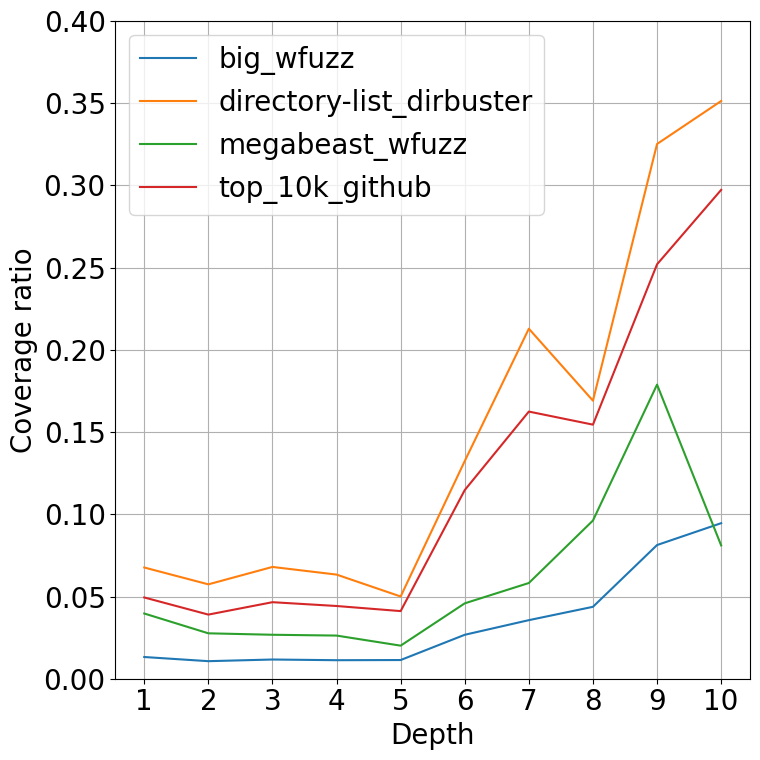

In [ ]:
# Set global font size
plt.rcParams['font.size'] = 20

datasets_name = {'university': 'Universities Dataset', 'government': 'Government Dataset', 'hospital': 'Hospitals Dataset', 'company': 'Companies Dataset'}

for i, t in enumerate(types):
    fig, ax = plt.subplots(figsize=(8,8))
    for j, wordlist_pair in enumerate(wordlists):
        coverage = coverages[(t, wordlist_pair[0])]
        ax.plot(range(1, max_depth+1), coverage, label=wordlist_pair[0])
    # ax.set_title(f'Coverage ratio per depth for {datasets_name[t]}')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Coverage ratio')
    ax.set_ylim(0, 0.4)
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    # plt.savefig(f"cover-{t}.pdf")
    plt.show()

## ANALYSIS OF DIRECTORIES DISTRIBUTIONS FOR EACH DEPTH

In [ ]:
types=df['Type'].unique()
type_distribution={}
for type in types:
    depth_dir_count={}
    df_type=df[df['Type']==type]
    websites=df_type['Filename'].unique()
    for website in websites:
        website_df=df_type[df_type['Filename']==website]
        dir_set={}
        for path_list in website_df['Directories']:
            for i in range(len(path_list)):
                if i+1 not in dir_set:
                    dir_set[i+1]=set()
                dir_set[i+1].add(path_list[i])
        for depth in dir_set:
            if depth not in depth_dir_count:
                depth_dir_count[depth]=[]
            depth_dir_count[depth]=depth_dir_count[depth]+list(dir_set[depth])
    
    type_distribution[type]=depth_dir_count


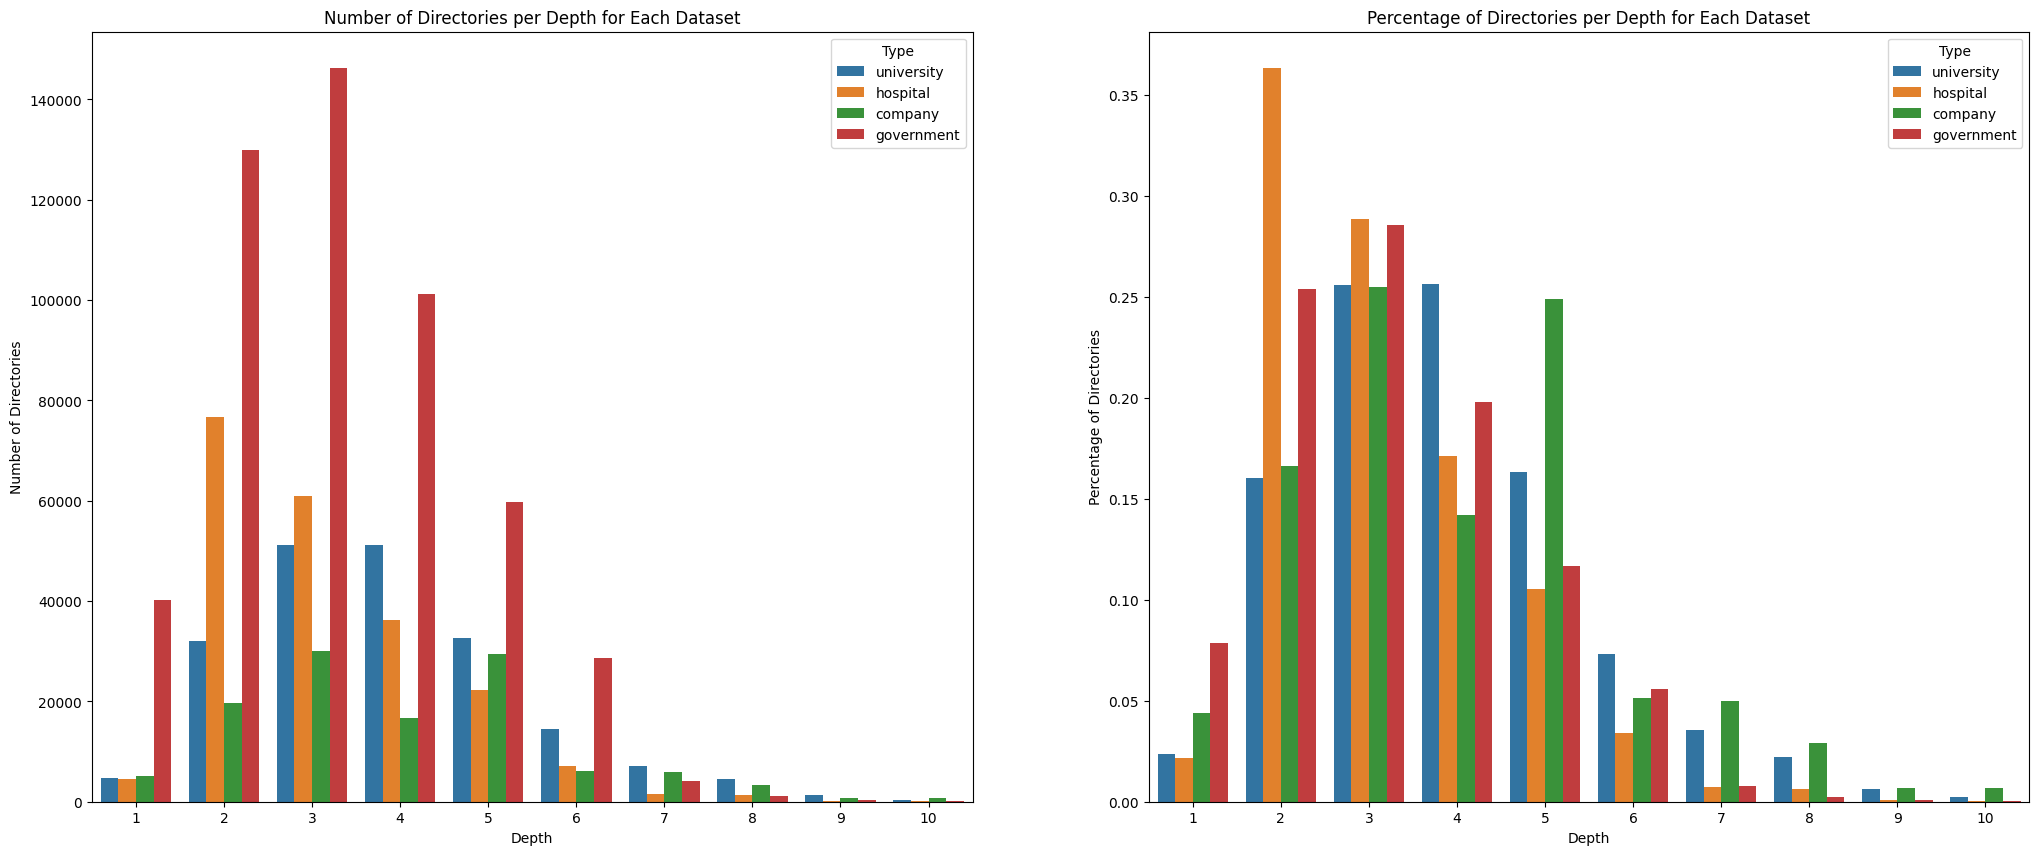

In [ ]:
# Plot the distribution of directories per depth for each dataset type in a unique plot (trim depth to 10)
# Plotting
data = []
per_data=[]
for type, depth_dir_count in type_distribution.items():
    for depth, dirs in depth_dir_count.items():
        if depth <= 10:
            data.append([depth, type, len(dirs)])


df_plot = pd.DataFrame(data, columns=['Depth', 'Type', 'Number of Directories'])
total_directories_per_type = df_plot.groupby('Type')['Number of Directories'].sum()
df_plot['Percentage of Directories'] = df_plot.apply(lambda row: row['Number of Directories'] / total_directories_per_type[row['Type']] , axis=1)
# Plotting 2 plot side by side, 1 with the number of directories and 1 with the percentage of directories
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
sns.barplot(x='Depth', y='Number of Directories', hue='Type', data=df_plot, ax=axs[0])
axs[0].set_title('Number of Directories per Depth for Each Dataset')
sns.barplot(x='Depth', y='Percentage of Directories', hue='Type', data=df_plot, ax=axs[1])
axs[1].set_title('Percentage of Directories per Depth for Each Dataset')
plt.show()


In [ ]:
# Create a unique dataset with path, path depth, and type using pd
df['Depth'] = df['Directories'].apply(len)
new_df = df[['Path', 'Depth', 'Type']]
new_df.head()
new_df=new_df[new_df['Depth']<=10]

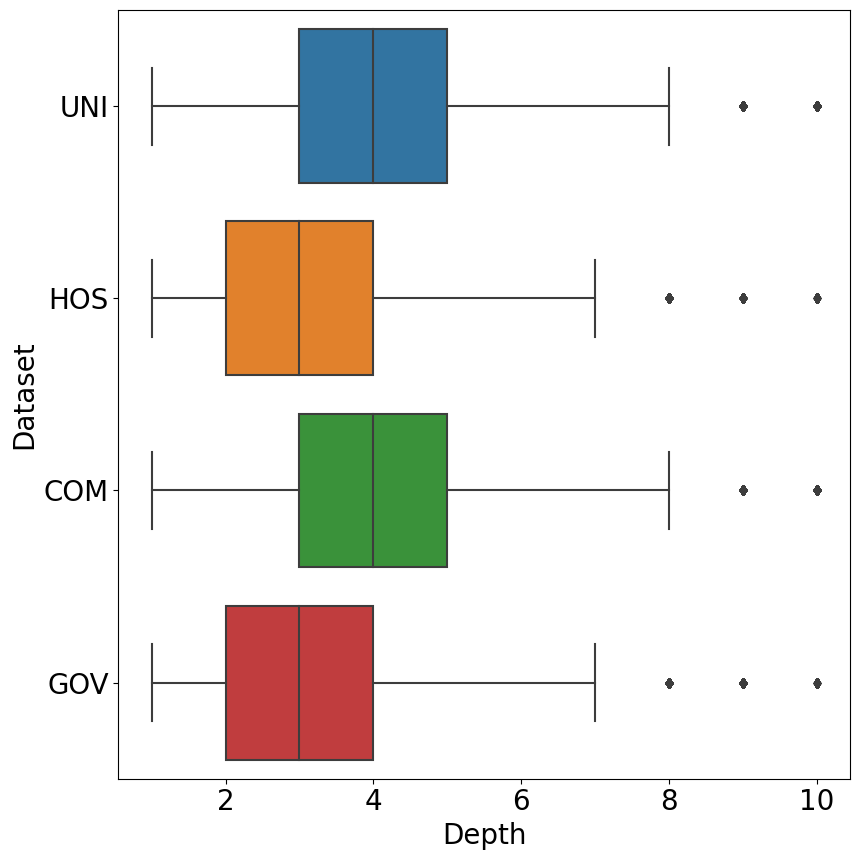

In [ ]:

fig, axs = plt.subplots(figsize=(9, 9))

mapper = {
 'university': 'UNI',
 'hospital': 'HOS',
 'company': 'COM',
  'government': 'GOV'
}
# Rename types of the new_df with the mapper
new_df.loc[:, 'Type'] = new_df['Type'].replace(mapper)

types_mapped = [mapper[x] for x in types]
# Box Plot
sns.boxplot(x='Depth', y='Type', data=new_df)
axs.set_ylabel('Dataset')

plt.tight_layout()
# plt.savefig('depth_distribution.pdf')
plt.show()

## SIMILARITY BETWEEN WORDLISTS

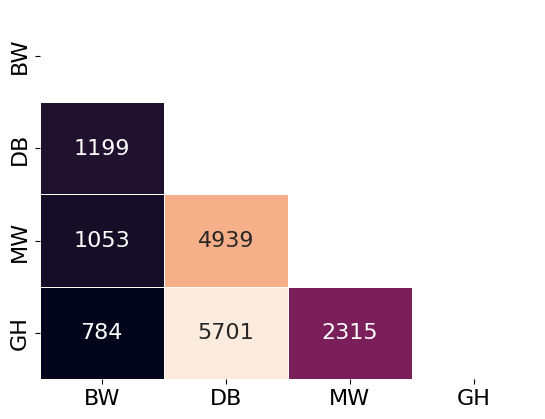

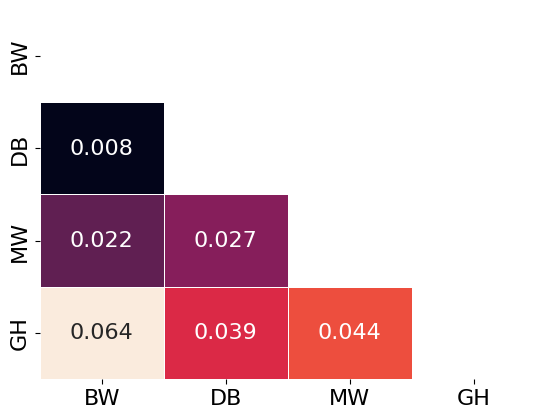

In [ ]:
# Heatmap of how many words in common every couple of wordlists in chosen_wordlists 
wordlists_folder = 'chosen_wordlists'

selected_wordlists = []  # Store the selected wordlists

for root, dirs, files in os.walk(wordlists_folder):
    for filename in files:
        if filename.endswith('.txt'):
            selected_wordlists.append(os.path.join(root, filename))

wordlists = []

for wordlist_file in selected_wordlists:
    with open(wordlist_file, 'r') as file:
        wordlist_content = file.read()
        wordlist_words = wordlist_content.split()  # Split the content into words
        wordlist_set = set(wordlist_words)  # Create a set from the words
        wordlists.append((os.path.basename(wordlist_file), wordlist_set))

# Heatmap of how many words in common every couple of wordlists in chosen_wordlists
similarity = np.zeros((len(wordlists), len(wordlists)))

for i, (name1, wordlist1) in enumerate(wordlists):
    for j, (name2, wordlist2) in enumerate(wordlists):
        similarity[i, j] = len(wordlist1 & wordlist2)

mapper = {
 'big_wfuzz.txt': 'BW',
 'top_10k_github.txt': 'GH',
 'megabeast_wfuzz.txt': 'MW',
  'directory-list_dirbuster.txt': 'DB'
}

for i in range(len(wordlists)):
    name, _ = wordlists[i]
    wordlists[i] = (mapper[name], _)

plt.rcParams['font.size'] = 16
# plt.figure(figsize=(6, 6))
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(similarity)
sns.heatmap(similarity, annot=True, xticklabels=[name for name, _ in wordlists], yticklabels=[name for name, _ in wordlists], cbar=False, linewidth=.5, fmt=".0f", mask= matrix)
# plt.title('Number of common words between each couple of wordlists')
plt.savefig('words_in_common.pdf')
plt.show()
# Heatmap with jaccard similarity between each couple of wordlists
jaccard_similarity = np.zeros((len(wordlists), len(wordlists)))

for i, (name1, wordlist1) in enumerate(wordlists):
    for j, (name2, wordlist2) in enumerate(wordlists):
        jaccard_similarity[i, j] = len(wordlist1 & wordlist2) / len(wordlist1 | wordlist2)

plt.rcParams['font.size'] = 16
# plt.figure(figsize=(6, 6))
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(jaccard_similarity)
sns.heatmap(jaccard_similarity, annot=True, xticklabels=[name for name, _ in wordlists], yticklabels=[name for name, _ in wordlists], cbar=False, linewidth=.5, fmt=".3f", mask= matrix)
# plt.title('Jaccard similarity between each couple of wordlists')
plt.savefig('wordlist_similarity.pdf')
plt.show()



## STEMMING ANALYSIS

In [ ]:
porter_stemmer = PorterStemmer()
# Stemming the directories
for type in types:
    stemmed_directories = set()
    directories=set()
    df_type=df[df['Type']==type]
    for directories_list in df_type['Directories']:
        directories.update(directories_list)
    for directory in directories:
        stemmed_directories.add(porter_stemmer.stem(directory))
    og_size=len(directories)
    stem_size=len(stemmed_directories)
    print(f'Dataset type: {type}')
    print(f'\nNumber of unique directories: {og_size}')
    print(f'Number of unique stemmed directories: {stem_size}')
    print(f'Reduction: {og_size-stem_size}')
    print(f'Reduction percentage: {(og_size-stem_size)/og_size*100:.2f}%\n')

In [ ]:
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()
# Use df as base, for every 'Type', for every 'domain', get the set of directories, and each record shoud have "Type", "Domain", "Directory", "Stem"

# Stemming the directories
stem_df=pd.DataFrame(columns=['Type', 'Domain', 'Directory', 'Stem'])
for type in tqdm(df['Type'].unique(),desc='types'):
    df_type=df[df['Type']==type]
    websites=df_type['Filename'].unique()
    new_df=pd.DataFrame(columns=['Type', 'Domain', 'Directory', 'Stem'])
    for website in tqdm(websites,desc='websites'):
        website_df=df_type[df_type['Filename']==website]

        dir_set=set()
        for path_list in website_df['Directories']:
            dir_set.update(path_list)
        local_df=pd.DataFrame(columns=['Type', 'Domain', 'Directory', 'Stem'])
        records_list=[]
        for directory in dir_set:
            records_list.append([type, website, directory, porter_stemmer.stem(directory)])
        local_df=pd.DataFrame(records_list,columns=['Type', 'Domain', 'Directory', 'Stem'])
        new_df=pd.concat([new_df,local_df],ignore_index=True)
    stem_df=pd.concat([stem_df,new_df],ignore_index=True)


In [ ]:
stem_df.head()

,Type,Domain,Directory,Stem
0,university,https__www.ucl.ac.uk_.csv,upgrade,upgrad
1,university,https__www.ucl.ac.uk_.csv,study-dpu,study-dpu
2,university,https__www.ucl.ac.uk_.csv,demarginalizing-medieval-africa-news,demarginalizing-medieval-africa-new
3,university,https__www.ucl.ac.uk_.csv,2146630355,2146630355
4,university,https__www.ucl.ac.uk_.csv,2146641411,2146641411


In [ ]:
# Create a new df where you drop domain column and drop duplicates
stem_df_no_domain=stem_df.drop(columns=['Domain'])
stem_df_no_domain=stem_df_no_domain.drop_duplicates()

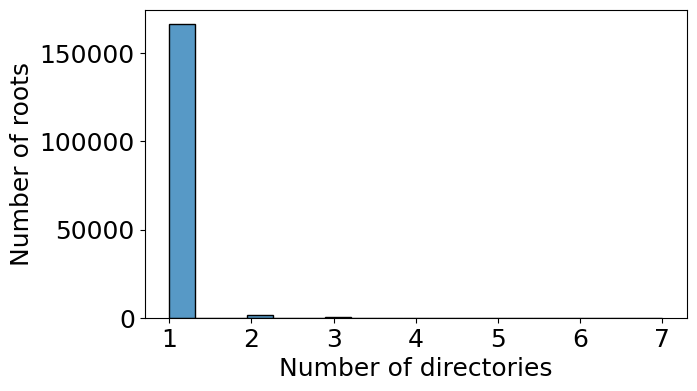

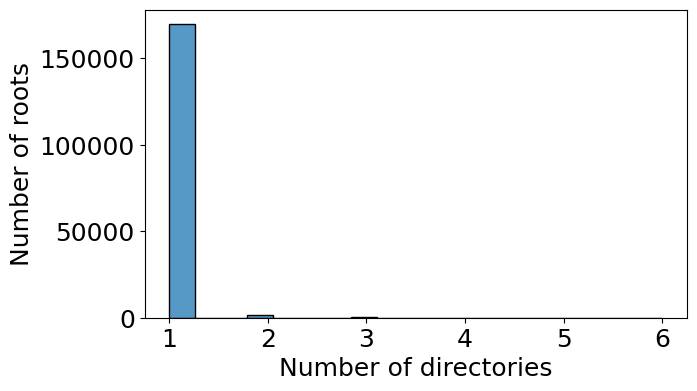

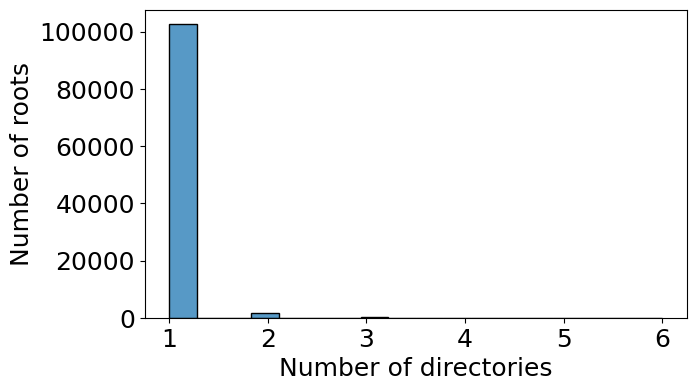

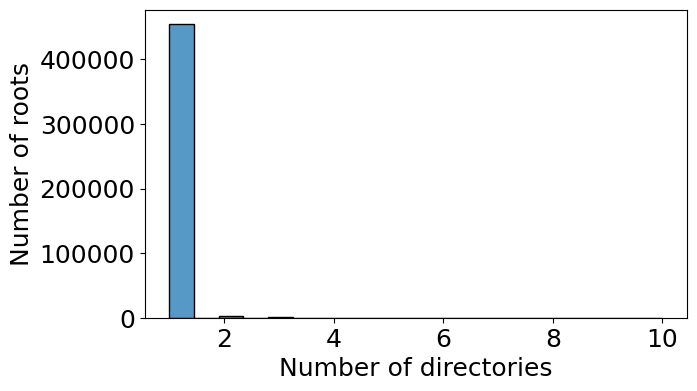

In [ ]:
# For each Type, group directories by stem and plot a kde plot that shows the number of different directories for each stem

# Plotting
plt.rcParams['font.size'] = 18
# fig, axs = plt.subplots(1, 4, figsize=(25, 10))
for i, t in enumerate(stem_df_no_domain['Type'].unique()):
    local_df=stem_df_no_domain[stem_df_no_domain['Type']==t]

    stem_counts = local_df['Stem'].value_counts()
    
    # Convert the series to a DataFrame for easier plotting
    stem_counts_df = stem_counts.reset_index()
    # print(stem_counts_df.head())
    # Counter for the number of directories per stem
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(stem_counts_df['count'], kde=False,ax=ax)
    # plt.title('Distribution of Directory Counts per Stem')
    ax.set_xlabel('Number of directories')
    ax.set_ylabel('Number of roots')
    # plt.yscale('log')
    plt.savefig(f'stemming-{t}.pdf',bbox_inches='tight')
    plt.show()
   

## SIMULATION ANALYSIS


In [10]:
benchmark_df=pd.read_csv('benchmark_results.csv')
benchmark_df.head()

,Dataset,Simulation,Wordlist,Total_requests,successful_responses,failed_responses
0,university,breadth,big_wfuzz,1,0,1
1,university,breadth,big_wfuzz,21,0,21
2,university,breadth,big_wfuzz,41,0,41
3,university,breadth,big_wfuzz,61,0,61
4,university,breadth,big_wfuzz,81,0,81


### PLOT AVG_SUCCESSFUL_RESULTS EVOLUTION FOR EVERY SIMULATION TYPE

In [11]:
benchmark_df['Wordlist'].unique()

#Rename breadth as Breadth-First, depth as Depth-First in the simulation column
benchmark_df['Simulation']=benchmark_df['Simulation'].replace('breadth','Breadth-First')
benchmark_df['Simulation']=benchmark_df['Simulation'].replace('depth','Depth-First')

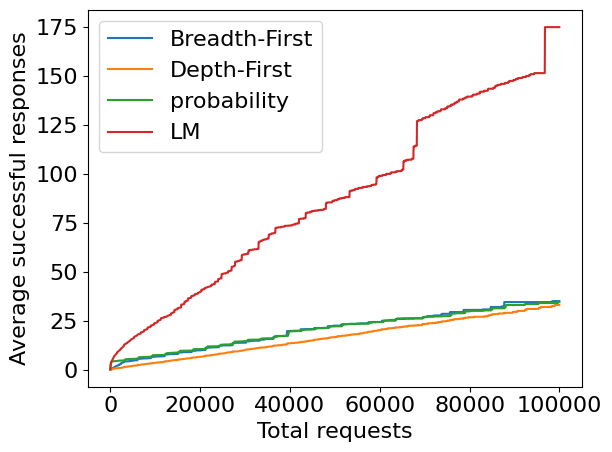

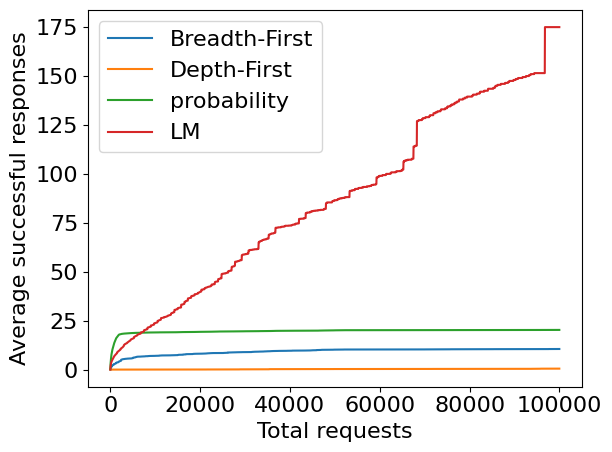

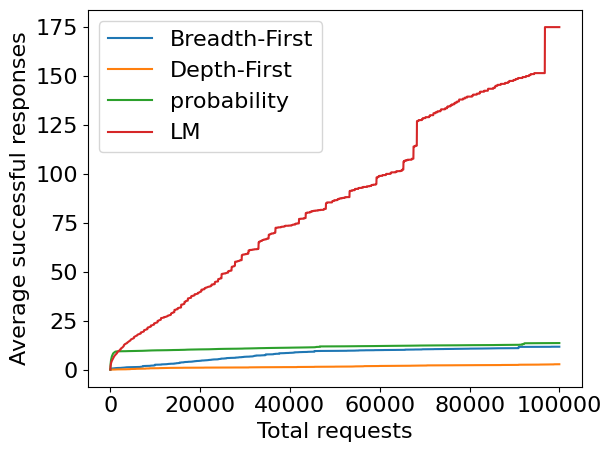

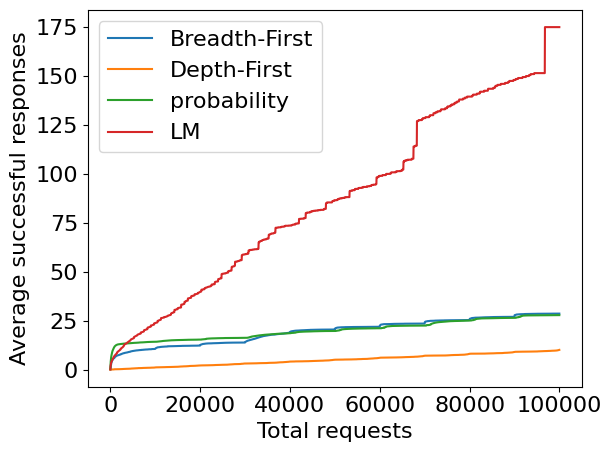

In [5]:
# Set font size 
plt.rcParams['font.size'] = 16

simulation_types=benchmark_df['Simulation'].unique()
wordlist_names = [os.path.splitext(os.path.basename(file))[0] for file in os.listdir('chosen_wordlists')]
for i, wordlist in enumerate(wordlist_names):
    wordlist_list=[wordlist,'general']
    df_wordlist = benchmark_df[benchmark_df ['Wordlist'].isin(wordlist_list)]
    
    for simulation in simulation_types:
        df_simulation = df_wordlist[df_wordlist['Simulation'] == simulation]
        avg_successful_responses = df_simulation.groupby('Total_requests')['successful_responses'].mean().reset_index()
        avg_successful_responses['Simulation'] = simulation
        
        #Plot a line with plt and label simulation, x total requests, y successful responses
        plt.plot(avg_successful_responses['Total_requests'],avg_successful_responses['successful_responses'], label=simulation)
    
    # plt.title(f'Average Successful Responses for {wordlist}')
    plt.legend()
    plt.ylabel('Average successful responses')
    plt.xlabel('Total requests')
    plt.tight_layout()
    plt.show()  
# Show the figure

# Show the figure


### Print average number of successful responses for each simulation, for each wordlist, for each category

In [18]:
print('Average number of successful responses after reaching request limit for each simulation, for each wordlist, for each category')
categories=list(benchmark_df['Dataset'].unique())

wordlist_names = [os.path.splitext(os.path.basename(file))[0] for file in os.listdir('chosen_wordlists')]

breadth_df=benchmark_df[benchmark_df['Simulation']=='Breadth-First']
print('Simulation: breadth-first')
for wordlist_name in wordlist_names:
    wordlist_df=breadth_df[breadth_df['Wordlist']==wordlist_name]
    vals=[]
    for category in categories:
        local_df=wordlist_df[wordlist_df['Dataset']==category]
        avg_successful_responses = local_df.groupby('Total_requests')['successful_responses'].mean().reset_index()
        max_r= avg_successful_responses['Total_requests'].max()
        vals.append(round(avg_successful_responses[avg_successful_responses["Total_requests"]==max_r]["successful_responses"].values[0],1))
    print(f'  {wordlist_name} {vals}')

depth_df=benchmark_df[benchmark_df['Simulation']=='Depth-First']
print('Simulation: depth-first')
for wordlist_name in wordlist_names:
    wordlist_df=depth_df[depth_df['Wordlist']==wordlist_name]
    vals=[]
    for category in categories:
        local_df=wordlist_df[wordlist_df['Dataset']==category]
        avg_successful_responses = local_df.groupby('Total_requests')['successful_responses'].mean().reset_index()
        max_r= avg_successful_responses['Total_requests'].max()
        vals.append(round(avg_successful_responses[avg_successful_responses["Total_requests"]==max_r]["successful_responses"].values[0],1))
    print(f'  {wordlist_name} {vals}')

# probability part
probability_df=benchmark_df[benchmark_df['Simulation']=='probability']
print('Simulation: probability')
for wordlist_name in wordlist_names:
    wordlist_df=probability_df[probability_df['Wordlist']==wordlist_name]
    vals=[]
    for category in categories:
        local_df=wordlist_df[wordlist_df['Dataset']==category]
        avg_successful_responses = local_df.groupby('Total_requests')['successful_responses'].mean().reset_index()
        max_r= avg_successful_responses['Total_requests'].max()
        vals.append(round(avg_successful_responses[avg_successful_responses["Total_requests"]==max_r]["successful_responses"].values[0],1))
    print(f'  {wordlist_name} {vals}')
    
wordlist_df=probability_df[probability_df['Wordlist']=='train-set']
wordlist_name='train-set'
vals=[]
for category in categories:
    local_df=wordlist_df[wordlist_df['Dataset']==category]
    avg_successful_responses = local_df.groupby('Total_requests')['successful_responses'].mean().reset_index()
    max_r= avg_successful_responses['Total_requests'].max()
    vals.append(round(avg_successful_responses[avg_successful_responses["Total_requests"]==max_r]["successful_responses"].values[0],1))
print(f'  {wordlist_name} {vals}')

print('Simulation: LM')
lm_df=benchmark_df[benchmark_df['Simulation']=='LM']
vals=[]
for category in categories:
    local_df=lm_df[lm_df['Dataset']==category]
    avg_successful_responses = local_df.groupby('Total_requests')['successful_responses'].mean().reset_index()
    max_r= avg_successful_responses['Total_requests'].max()
    vals.append(round(avg_successful_responses[avg_successful_responses["Total_requests"]==max_r]["successful_responses"].values[0],1))
print(f'  general {vals}')

        

Average number of successful responses after reaching request limit for each simulation, for each wordlist, for each category
Simulation: breadth-first
  big_wfuzz [28.0, 22.0, 27.0, 35.0, 35.0]
  directory-list_dirbuster [8.0, 10.3, 9.6, 11.8, 10.5]
  megabeast_wfuzz [10.5, 11.6, 11.0, 12.4, 11.7]
  top_10k_github [21.3, 42.6, 26.8, 27.0, 28.6]
Simulation: depth-first
  big_wfuzz [28.0, 22.0, 27.0, 33.0, 33.0]
  directory-list_dirbuster [0.5, 0.5, 0.7, 0.4, 0.5]
  megabeast_wfuzz [2.6, 2.9, 2.7, 2.7, 2.7]
  top_10k_github [10.1, 10.1, 10.1, 10.0, 10.1]
Simulation: probability
  big_wfuzz [28.0, 22.0, 27.0, 34.5, 34.5]
  directory-list_dirbuster [14.0, 13.1, 11.1, 17.3, 25.4]
  megabeast_wfuzz [12.5, 13.9, 11.8, 13.8, 13.8]
  top_10k_github [23.4, 42.9, 26.1, 27.1, 26.7]
  train-set [31.9, 60.4, 27.6, 30.8, 42.5]
Simulation: LM
  general [90.0, 175.0, 89.0, 128.0, 175.0]


### EFFICIENCY RATIO ANALYSIS

Dataset = university
wordlist = big_wfuzz


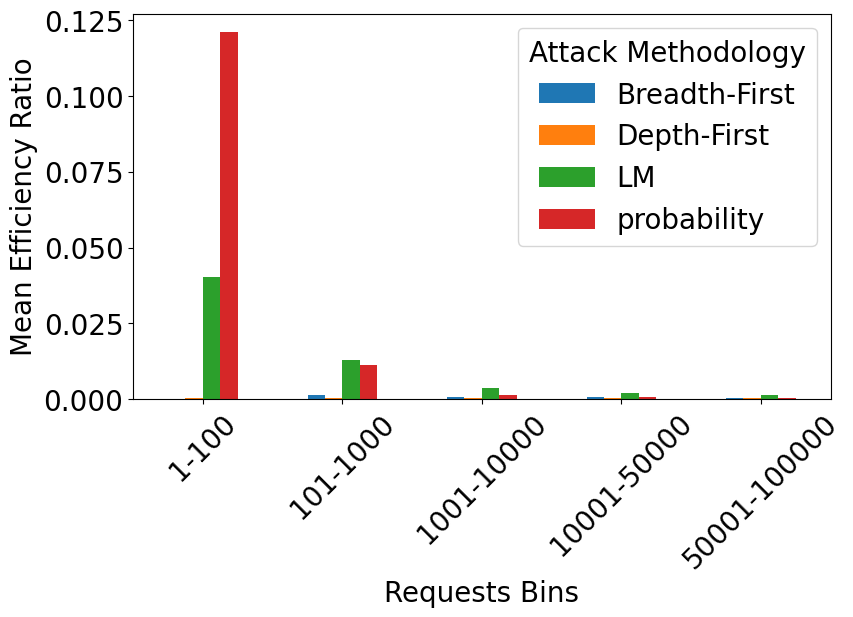

wordlist = directory-list_dirbuster


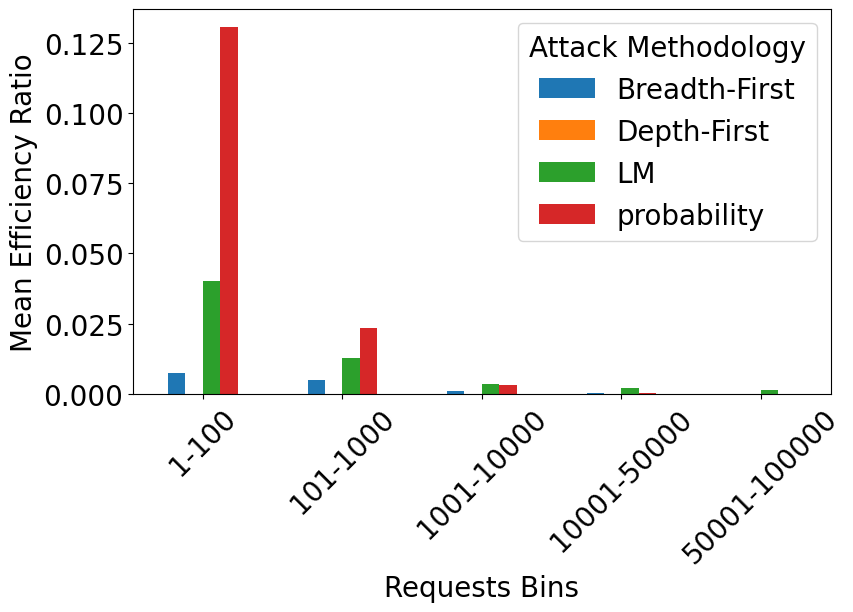

wordlist = megabeast_wfuzz


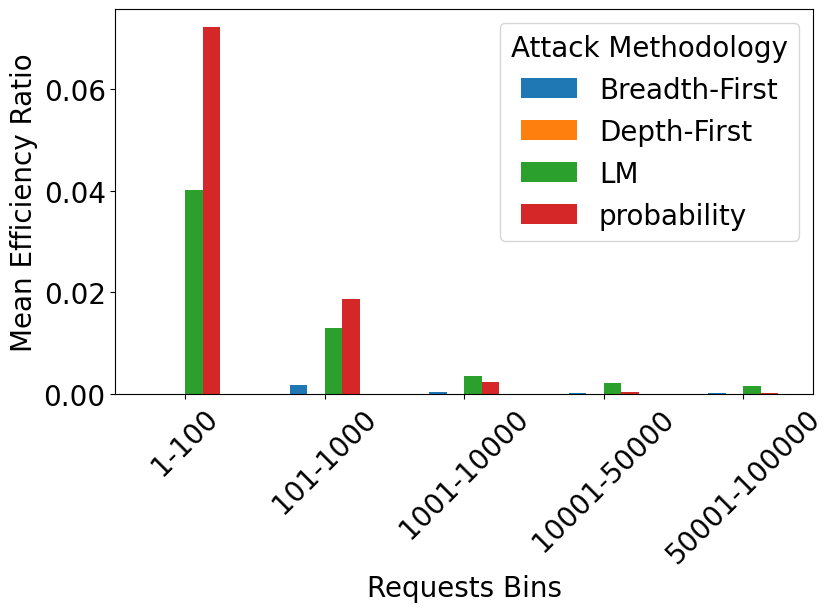

wordlist = top_10k_github


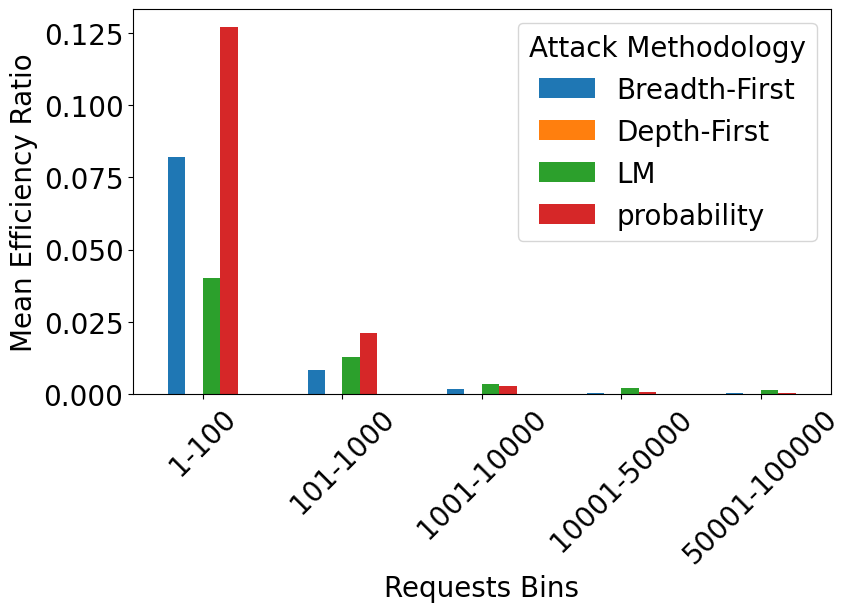

wordlist = train-set


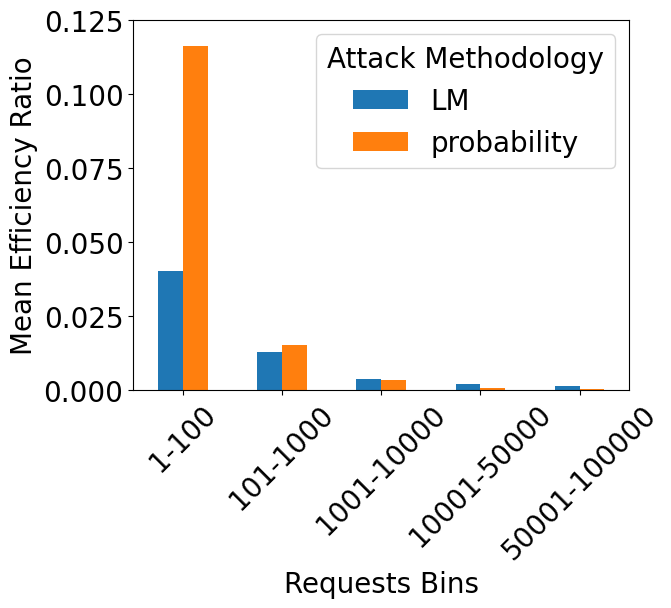

Dataset = hospital
wordlist = big_wfuzz


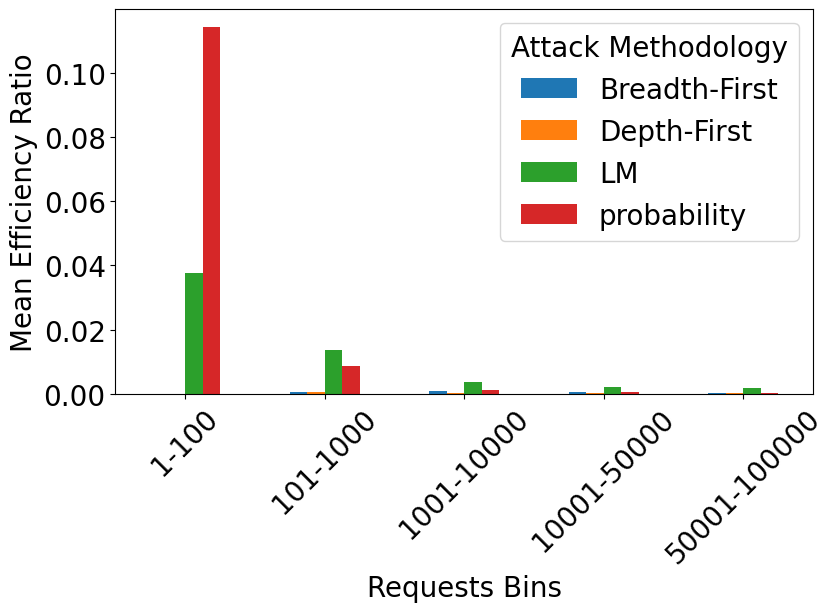

wordlist = directory-list_dirbuster


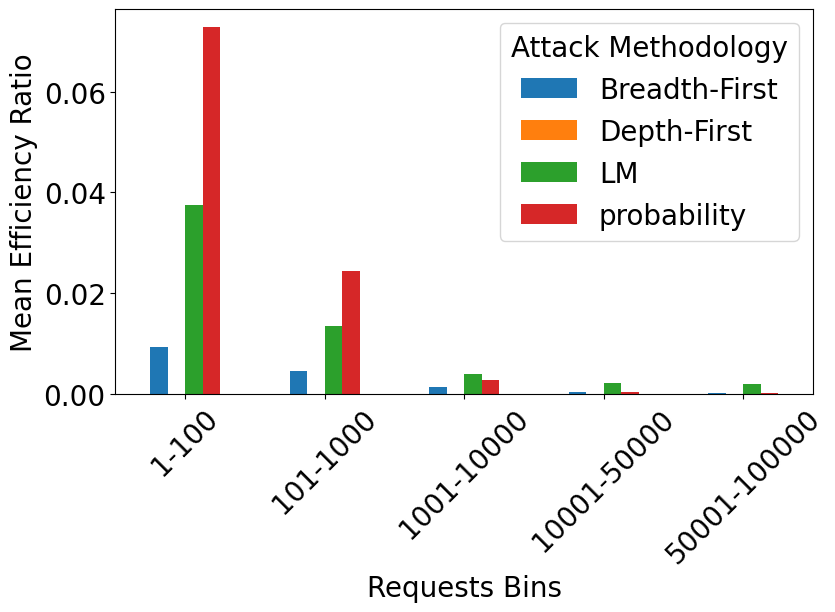

wordlist = megabeast_wfuzz


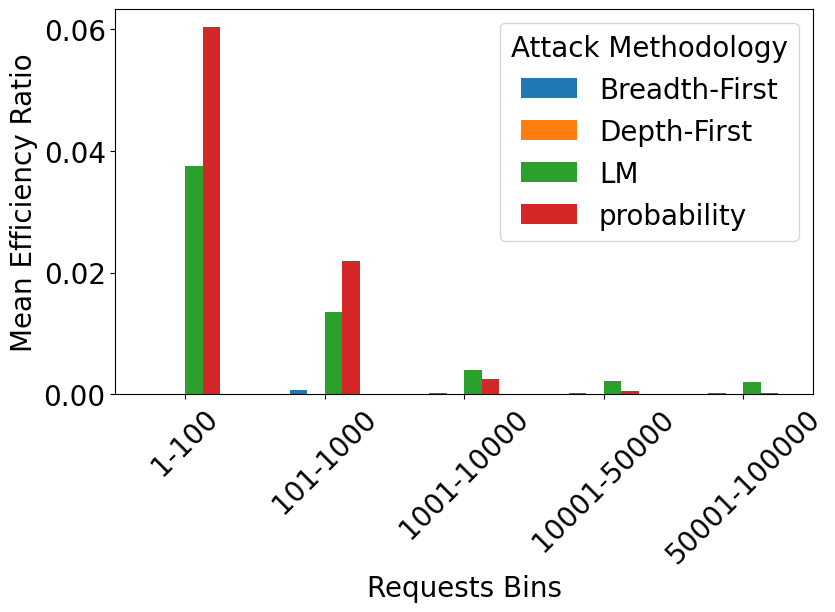

wordlist = top_10k_github


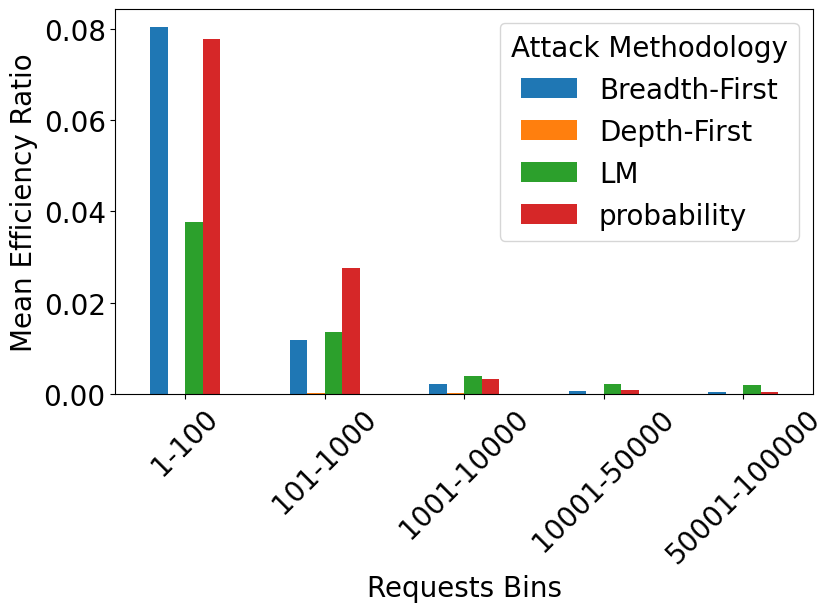

wordlist = train-set


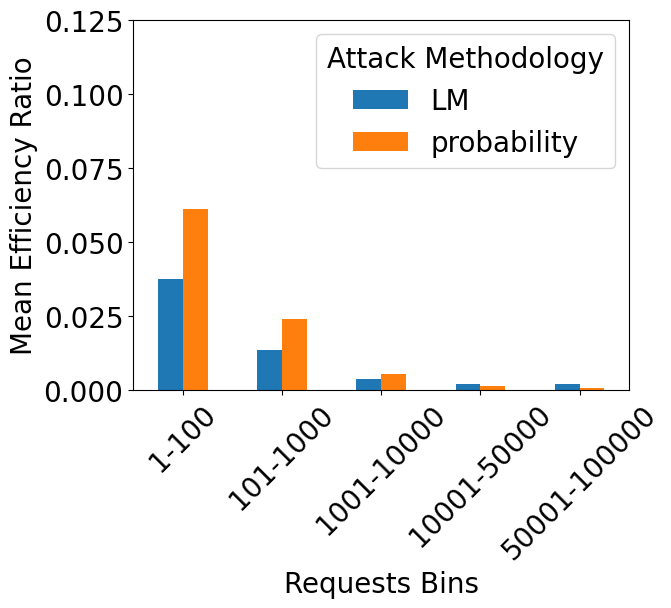

Dataset = company
wordlist = big_wfuzz


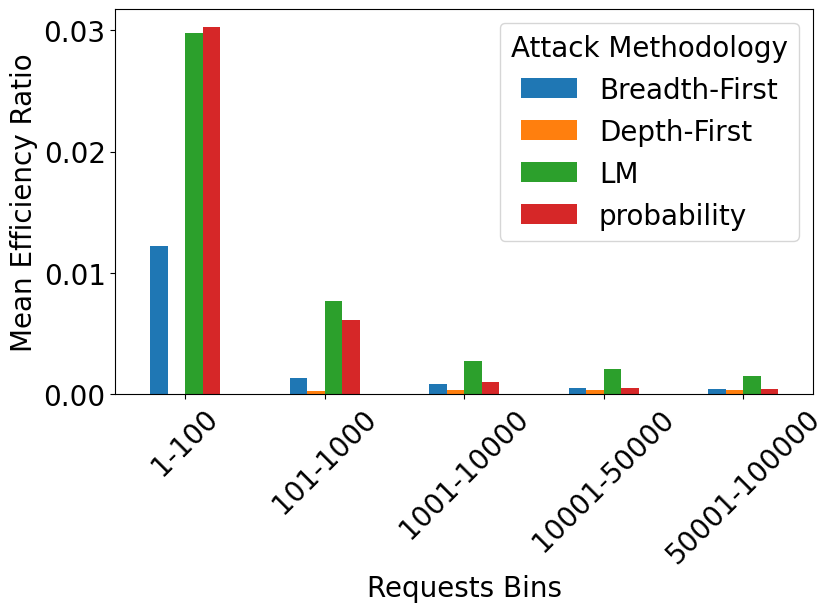

wordlist = directory-list_dirbuster


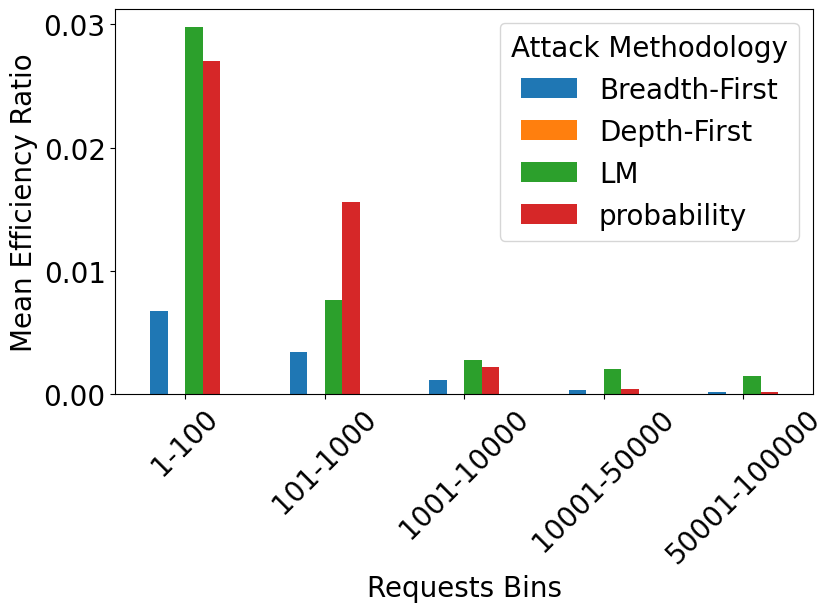

wordlist = megabeast_wfuzz


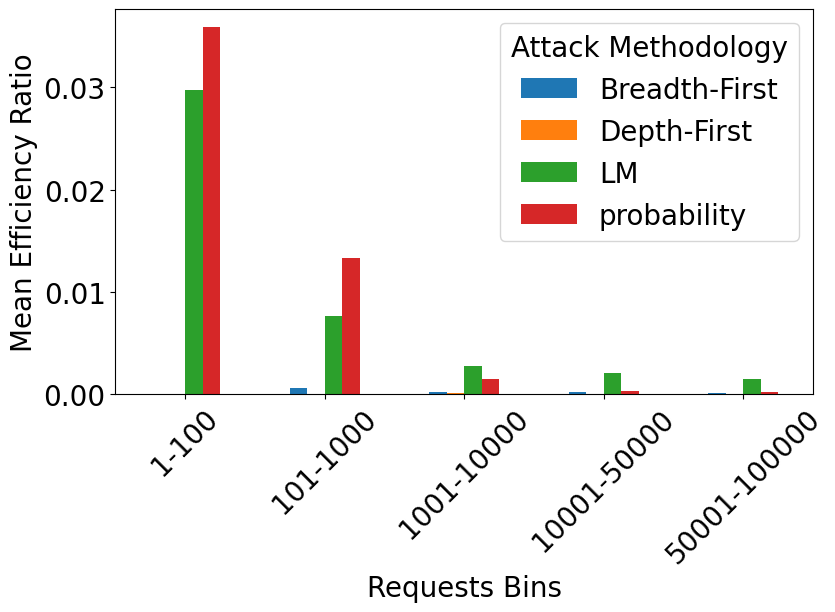

wordlist = top_10k_github


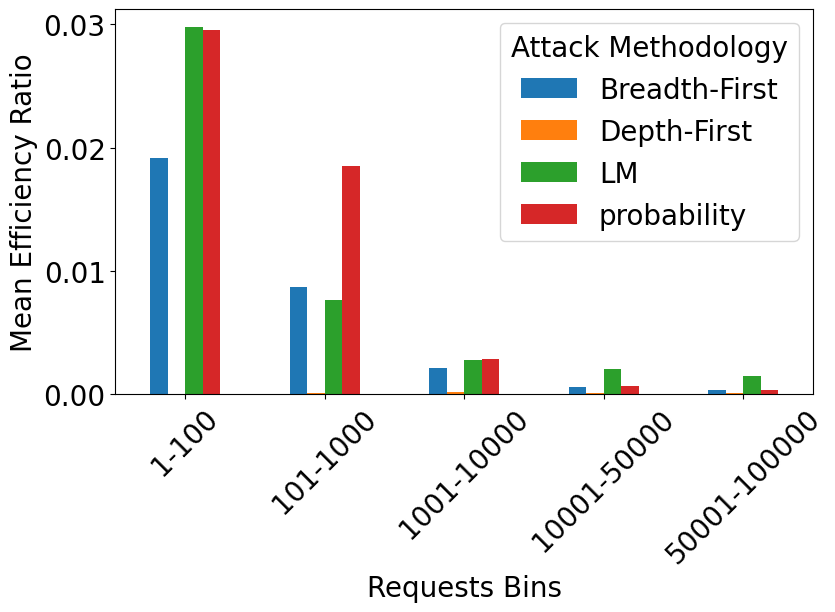

wordlist = train-set


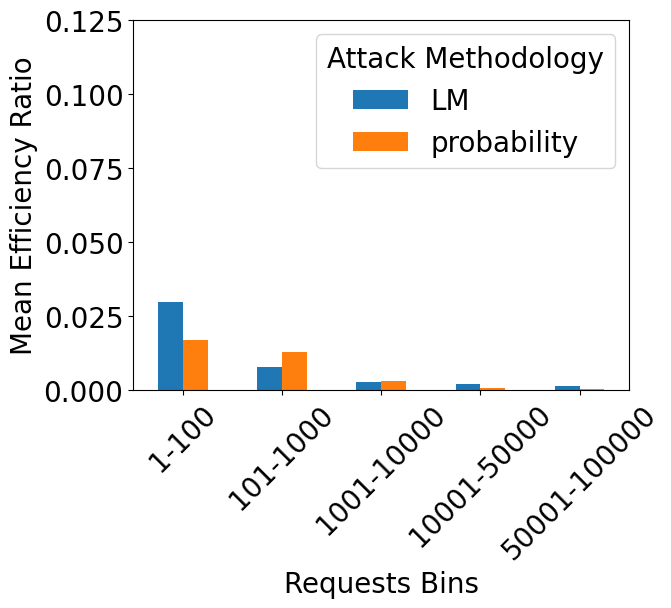

Dataset = government
wordlist = big_wfuzz


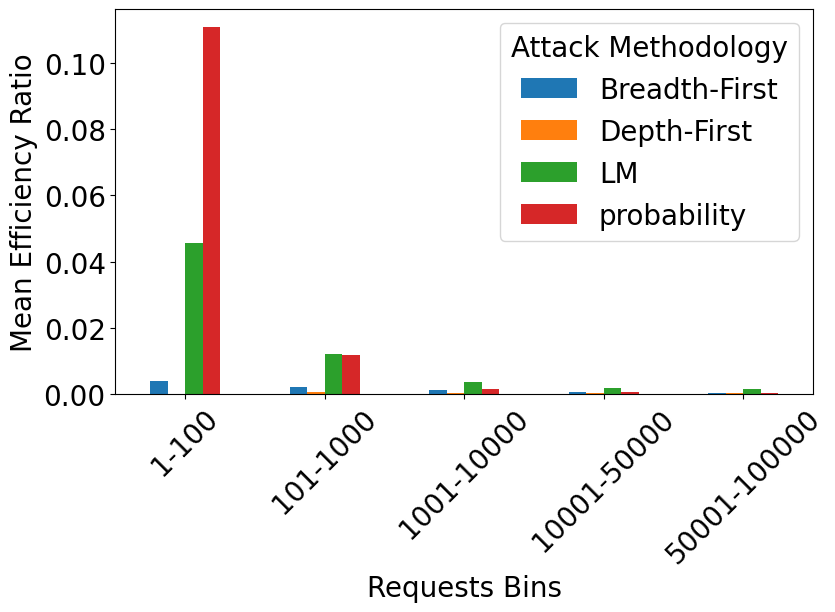

wordlist = directory-list_dirbuster


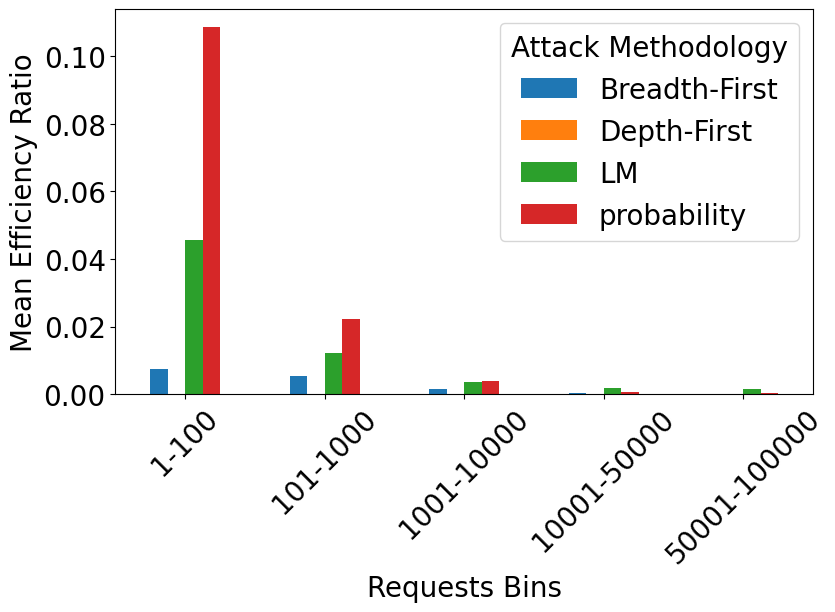

wordlist = megabeast_wfuzz


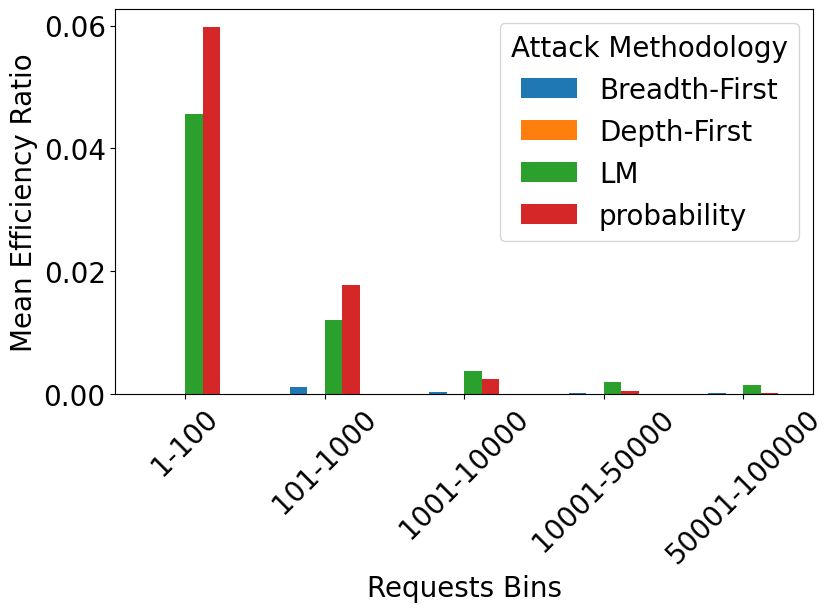

wordlist = top_10k_github


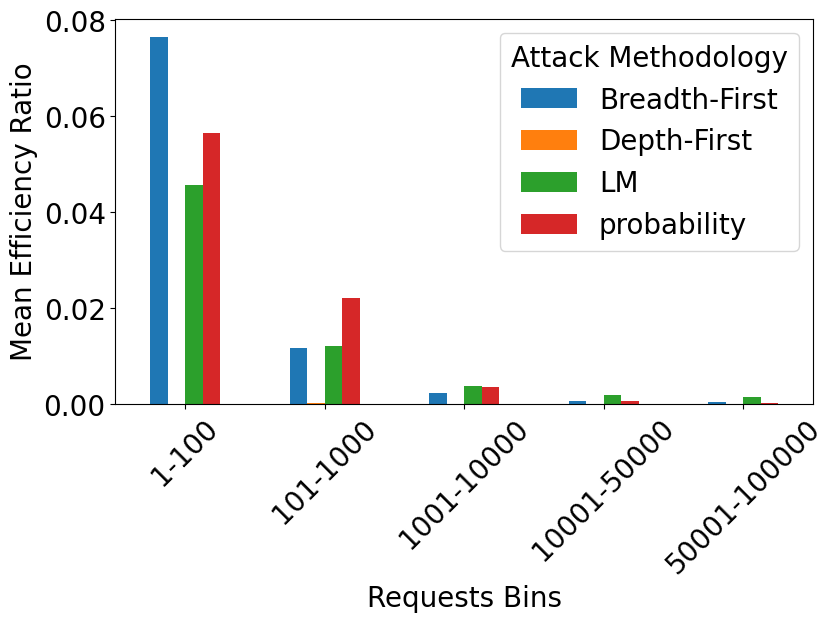

wordlist = train-set


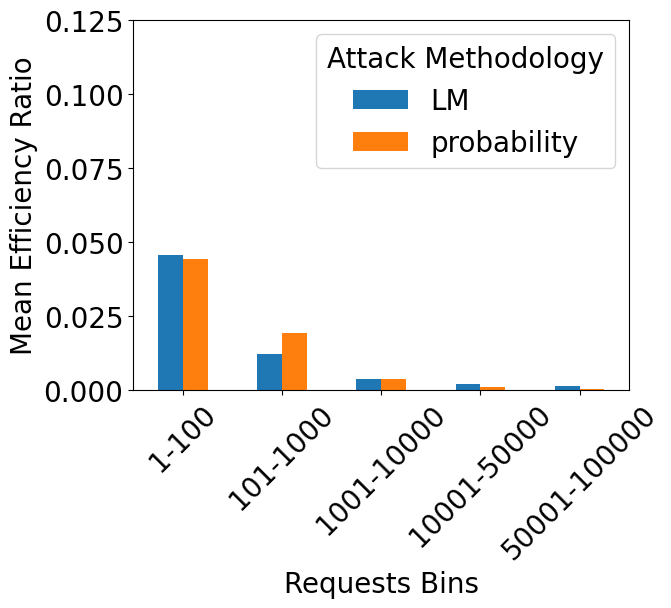

Dataset = general
wordlist = big_wfuzz


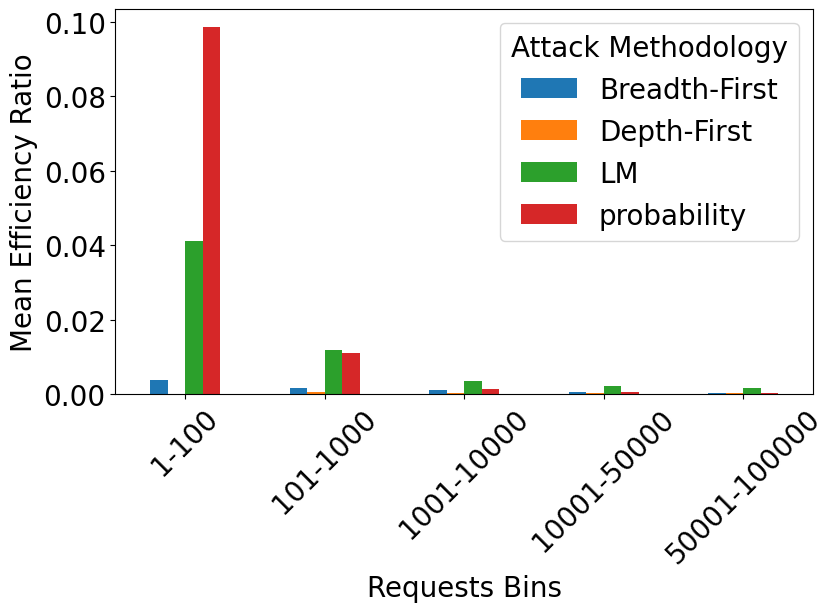

wordlist = directory-list_dirbuster


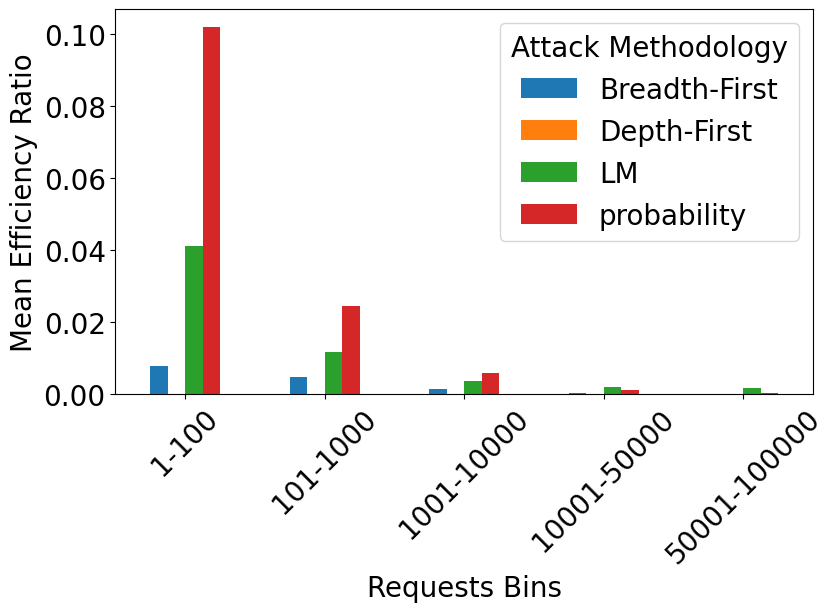

wordlist = megabeast_wfuzz


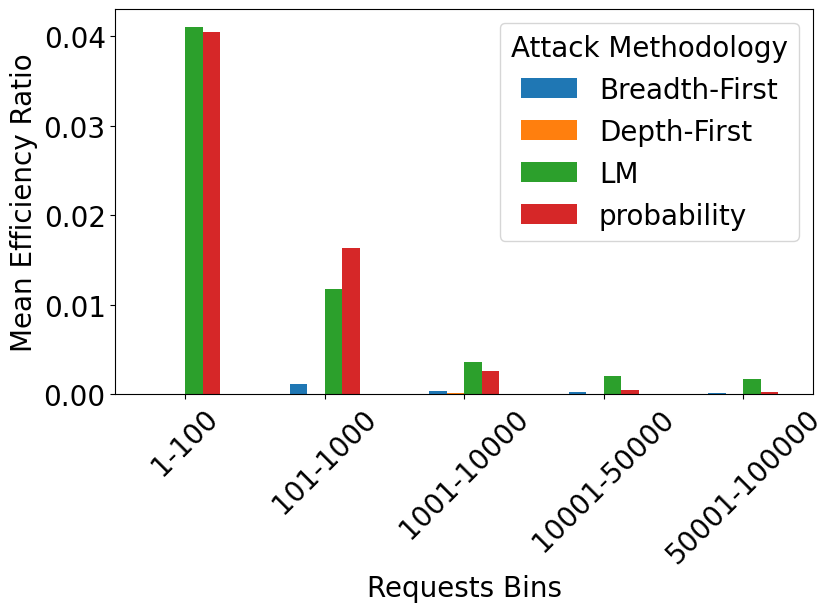

wordlist = top_10k_github


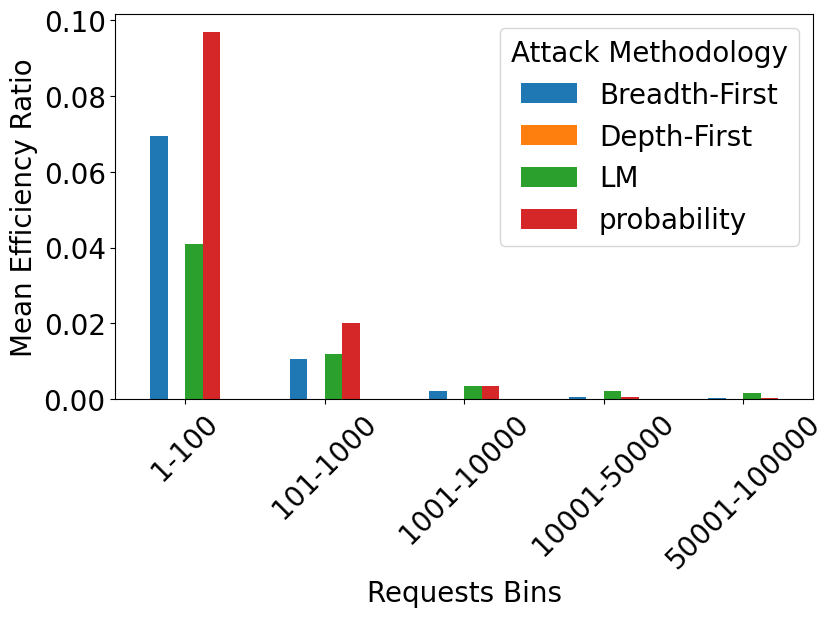

wordlist = train-set


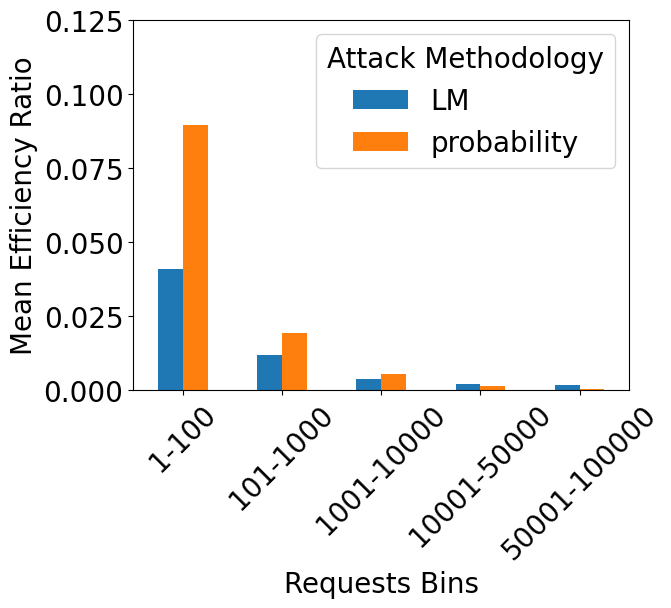

In [15]:
#set font size for plt globally
plt.rcParams['font.size'] = 20
wordlist_names = [os.path.splitext(os.path.basename(file))[0] for file in os.listdir('chosen_wordlists')]

for dataset in benchmark_df['Dataset'].unique():
    dataset_df=benchmark_df[benchmark_df['Dataset']==dataset].copy()  # Added .copy()
    print('Dataset =',dataset)
    for wordlist in wordlist_names:
        print(f'wordlist = {wordlist}')
        wordlists=['general', wordlist]
        combined_df=dataset_df[dataset_df['Wordlist'].isin(wordlists)].copy()  # Added .copy()
        #Add a new Efficiency column
        combined_df.loc[:, 'Efficiency'] = (combined_df['successful_responses'] / combined_df['Total_requests'])
        
        bins = [1,101, 1001, 10001,50001, 100000]
        labels = ['1-100','101-1000', '1001-10000', '10001-50000', '50001-100000']
        combined_df['bins'] = pd.cut(combined_df['Total_requests'], bins=bins, labels=labels, right=False)

        mean_efficiency = combined_df.groupby(['bins', 'Simulation'])['Efficiency'].mean().unstack()

        fig, ax = plt.subplots(figsize=(9, 5))
        mean_efficiency.plot(kind='bar', ax=ax)
        ax.set_ylabel('Mean Efficiency Ratio')
        ax.set_xlabel('Requests Bins')
        # ax.set_ylim(0,0.15)
        ax.legend(title='Attack Methodology')  # Set the legend title
        # ax.set_title('Mean Efficiency for Intervals of Total_requests by Simulation')
        plt.xticks(rotation=45)
        plt.savefig(f'efficiency_figures/{dataset}-{wordlist}.pdf',bbox_inches='tight')
        plt.show()

    print(f'wordlist = train-set')
    wordlists=['general', 'train-set']
    combined_df=dataset_df[dataset_df['Wordlist'].isin(wordlists)].copy()  # Added .copy()
    #Add a new Efficiency column
    combined_df.loc[:, 'Efficiency'] = (combined_df['successful_responses'] / combined_df['Total_requests'])
    
    bins = [1,101, 1001, 10001,50001, 100000]
    labels = ['1-100','101-1000', '1001-10000', '10001-50000', '50001-100000']
    combined_df['bins'] = pd.cut(combined_df['Total_requests'], bins=bins, labels=labels, right=False)

    mean_efficiency = combined_df.groupby(['bins', 'Simulation'])['Efficiency'].mean().unstack()

    fig, ax = plt.subplots()
    mean_efficiency.plot(kind='bar', ax=ax)
    ax.set_ylabel('Mean Efficiency Ratio')
    ax.set_xlabel('Requests Bins')
    ax.set_ylim(0,0.125)
    # ax.set_title('Mean Efficiency for Intervals of Total_requests by Simulation')
    ax.legend(title='Attack Methodology')  # Set the legend title
    plt.xticks(rotation=45)
    plt.savefig(f'efficiency_figures/{dataset}-train-set.pdf',bbox_inches='tight')
    plt.show()

